In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import io
import imageio
from IPython.display import Image, display
import nrrd
import os
import random

In [3]:
#Pick random train and val:
path= 'C:/Users/bvtran/OneDrive - Inside MD Anderson/Documents/MRL_data/RD_Center_cropped'
datadir= os.listdir(path)
remove=['2521725','2570357','2574697','2587907','895844','2547570']
for i in remove:
    datadir.remove(i)
train_dir=random.sample(datadir, 15)
for i in range(len(train_dir)):
    datadir.remove(train_dir[i])
val_dir=random.sample(datadir, 2)
train_path=[]
val_path=[]
for i in range(len(train_dir)):
    train_path.append(path+'/'+str(train_dir[i]))
for i in range(len(val_dir)):
    val_path.append(path+'/'+str(val_dir[i]))    
print("Number of train samples:", len(train_dir),": ",train_dir)
print("Number of test samples:", len(val_dir),": ",val_dir)

Number of train samples: 15 :  ['2609170', '2467929', '2139028', '2419611', '2510278', '2467000', '862797', '2413785', '2403028', '2541392', '2604993', '2455275', '2386449', '1049397', '2593206']
Number of test samples: 2 :  ['2377620', '2459017']


In [4]:
#Pick random train and val:
path= 'C:/Users/bvtran/OneDrive - Inside MD Anderson/Documents/MRL_data/RD_Center_cropped'
val_dir=['2377620', '2459017']
val_path=[]
for i in range(len(val_dir)):
    val_path.append(path+'/'+str(val_dir[i]))    
print("Number of test samples:", len(val_dir),": ",val_dir)

Number of test samples: 2 :  ['2377620', '2459017']


In [10]:
#Get training and val data:
img_size=(64,64)
val_dataset=get_data(val_path,img_size)

# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

# Apply the processing function to the datasets.
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Validation Dataset Shapes: (2, 3, 64, 64, 1), (2, 3, 64, 64, 1)


In [8]:
from scipy.ndimage import zoom


def clipped_zoom(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

In [9]:
def get_data(data_path,img_size):
    size=len(data_path)
    data = np.zeros((size,4,) + img_size + (1,))
    for i in range(size):
        path= os.listdir(data_path[i])
        Contour_path=[]
        for j in range(len(path)):
            if ("Contour" in path[j])==True:
                Contour_path.append(path[j])
        contours=[]
        for index in [0,1,2,-1]:
            contour, header = nrrd.read(data_path[i]+'/'+Contour_path[index])
            contour = clipped_zoom(contour, 2)
            contours.append(contour)
        contours=np.array(contours)
        data[i]=np.expand_dims(contours, 3)
    return data

In [6]:
#Get training and val data:
img_size=(64,64)
train_dataset=get_data(train_path,img_size)
val_dataset=get_data(val_path,img_size)

# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (15, 3, 64, 64, 1), (15, 3, 64, 64, 1)
Validation Dataset Shapes: (2, 3, 64, 64, 1), (2, 3, 64, 64, 1)


Displaying frames for example 5.


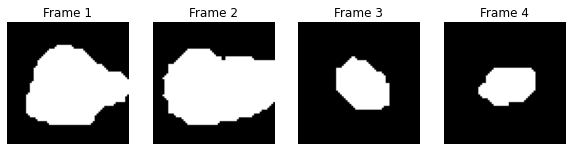

In [7]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(1, 4, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [8]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 64, 64, 1)] 0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, None, 64, 64, 64)  416256    
_________________________________________________________________
batch_normalization (BatchNo (None, None, 64, 64, 64)  256       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 64, 64, 64)  295168    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 64, 64, 64)  256       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 64, 64, 64)  33024     
_________________________________________________________________
conv3d (Conv3D)              (None, None, 64, 64, 1)  

In [49]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 25
batch_size = 5

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/25
3/3 [==============================] - 10s 3s/step - loss: 0.0269 - val_loss: 0.3747
Epoch 2/25
3/3 [==============================] - 9s 3s/step - loss: 0.0276 - val_loss: 0.3706
Epoch 3/25
3/3 [==============================] - 15s 5s/step - loss: 0.0265 - val_loss: 0.3664
Epoch 4/25
3/3 [==============================] - 12s 4s/step - loss: 0.0258 - val_loss: 0.3640
Epoch 5/25
3/3 [==============================] - 13s 4s/step - loss: 0.0277 - val_loss: 0.3625
Epoch 6/25
3/3 [==============================] - 12s 4s/step - loss: 0.0271 - val_loss: 0.3609
Epoch 7/25
3/3 [==============================] - 10s 3s/step - loss: 0.0248 - val_loss: 0.3588
Epoch 8/25
3/3 [==============================] - 11s 4s/step - loss: 0.0250 - val_loss: 0.3558
Epoch 9/25
3/3 [==============================] - 11s 4s/step - loss: 0.0246 - val_loss: 0.3545
Epoch 10/25
3/3 [==============================] - 12s 4s/step - loss: 0.0249 - val_loss: 0.3527
Epoch 11/25
3/3 [=======================

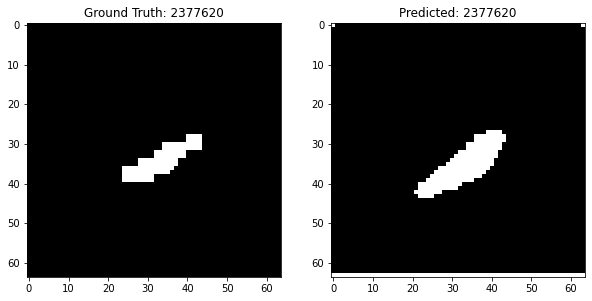

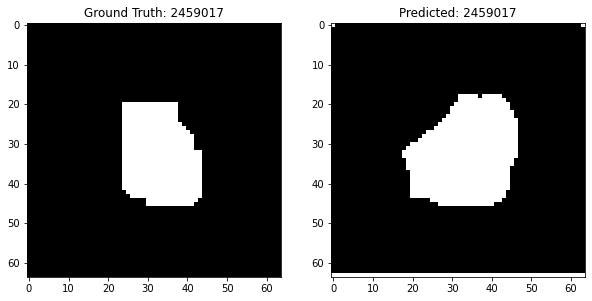

In [62]:
mask_predict=[]
mask_gt=[]
for i in range(len(val_dir)):
    example= val_dataset[i]
    # Pick the first/last ten frames from the example.
    frames = example[:3, ...]
    original_frames = example[3]
    original_frame=np.squeeze(original_frames)
    mask_gt.append(original_frame)
    
    # Predict a new frame.
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.squeeze(new_prediction[-1, ...], axis=2)
    for x in range(64):
        for y in range(64):
            if predicted_frame[x,y]>0.19:
                predicted_frame[x,y]=1
            else:
                predicted_frame[x,y]=0
    mask_predict.append(predicted_frame)
    # Construct a figure for the original and new frames.
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
    axes[0].imshow(original_frame, cmap="gray")
    axes[0].set_title(f"Ground Truth: {val_dir[i]}")
#     axes[0].axis("off")
    axes[1].imshow(predicted_frame, cmap="gray")
    axes[1].set_title(f"Predicted: {val_dir[i]}")
#     axes[1].axis("off")
    plt.show()

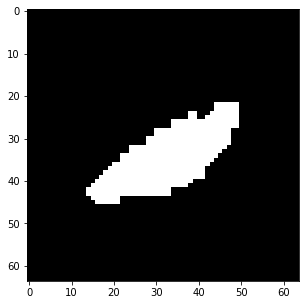

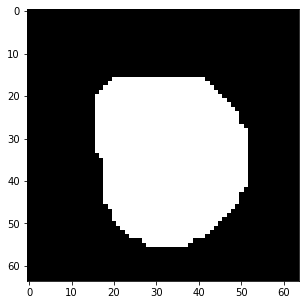

In [13]:
mask_gt=[]
for i in range(len(val_dir)):
    example= val_dataset[i]
    # Pick the first/last ten frames from the example.
    frames = example[:3, ...]
    original_frames = example[0]
    original_frame=np.squeeze(original_frames)
    mask_gt.append(original_frame)
    

    # Construct a figure for the original and new frames.
    fig, axes = plt.subplots(1, 1, figsize=(5, 5))
    axes.imshow(original_frame, cmap="gray")
    plt.show()

In [203]:
model.save('C:/Users/bvtran/OneDrive - Inside MD Anderson/Documents/MRL_data/python_code')

INFO:tensorflow:Assets written to: C:/Users/bvtran/OneDrive - Inside MD Anderson/Documents/MRL_data/python_code\assets


In [63]:
def DICE_COE(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3) # for easy reading
    return dice

In [64]:
dice=[]
for i in range(2):
    dice.append(DICE_COE(mask_gt[i],mask_predict[i]))
dice

[0.56, 0.739]

In [46]:
nrrd.write("LSTM_predictions",np.array(mask_predict))

In [47]:
nrrd.write("mask_gt",np.array(mask_gt))